Here's a prompt to challenge yourself and apply what you've learned about building agents in LangGraph. Try implementing the following task:

**Prompt: Build an AI Agent for a Simple Financial Calculator**

**Goal:**  
Create an AI agent that can perform the following financial calculations:  
1. Calculate simple interest.  
2. Calculate compound interest.  
3. Convert between different currencies (assume simple static conversion rates for now).  

**Requirements:**  
- Implement three tools: `simple_interest`, `compound_interest`, and `currency_convert`.  
- Use `LangGraph` to build a reactive agent that can:  
   - Choose the appropriate tool based on user input.  
   - Keep track of results and allow for multi-step calculations (e.g., calculate interest, then convert the result to another currency).  
- Implement memory so that the agent retains results between steps.  

**Details:**  
- **Simple Interest Formula:** \( I = P \times r \times t \)  
- **Compound Interest Formula:** \( A = P \times (1 + \frac{r}{n})^{n \times t} \)  
- **Currency Conversion:** Define a dictionary of conversion rates, e.g.,  
  ```python
  rates = {"USD_to_EUR": 0.85, "EUR_to_USD": 1.18}
  ```  

**Example User Flow:**  
1. User: "Calculate simple interest for principal 1000, rate 5%, and time 2 years."  
2. Agent: "The simple interest is 100."  
3. User: "Convert that to EUR."  
4. Agent: "100 USD is 85 EUR."  

**Stretch Goal:**  
- Add a tool to calculate loan payments using the formula for monthly payments on a fixed-rate mortgage.  
- Allow users to chain multiple operations without losing state.  

---

Try implementing this in stages:  
1. Define the tools.  
2. Set up the state graph.  
3. Implement memory to handle multi-step interactions.  

Let me know if you need hints or partial solutions along the way!

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [2]:
from langchain_openai import ChatOpenAI

def simple_interest(P: float, r: float, t: int) -> float:
    """
    Calculate simple interest.

    Args:
        P (int): The principal amount.
        r (int): The annual interest rate (as a percentage).
        t (int): The time the money is invested for (in years).
    """
    return P * r * t

def compound_interest(P: float, r: float, n: int, t: int) -> float:
    """
    Calculate compound interest.

    Args:
        P (float): The principal amount.
        r (float): The annual interest rate (in decimal form).
        n (int): The number of times the interest is compounded per year.
        t (int): The time the money is invested for (in years).
    """
    return P * (1 + r / n) ** (n * t)

# Define conversion rates
rates = {
    "USD_to_EUR": 0.85,
    "EUR_to_USD": 1.18,
    "USD_to_GBP": 0.75,
    "GBP_to_USD": 1.33,
    "EUR_to_GBP": 0.88,
    "GBP_to_EUR": 1.14
}

# Currency conversion function
def currency_convert(amount: float, from_currency: str, to_currency: str) -> float:
    """Convert currency based on predefined rates.

    Args:
        amount (float): The amount to convert.
        from_currency (str): The currency to convert from (e.g., "USD").
        to_currency (str): The currency to convert to (e.g., "EUR").
    """
    key = f"{from_currency}_to_{to_currency}"
    if key in rates:
        return round(amount * rates[key], 2)
    else:
        raise ValueError(f"Conversion rate for {key} not available.")


In [3]:
tools = [simple_interest, compound_interest, currency_convert]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [10]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System Message
sys_msg = SystemMessage(
    content=(
        "You are a helpful assistant tasked with performing financial calculations on a set of inputs"
    )
)

# Node 
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

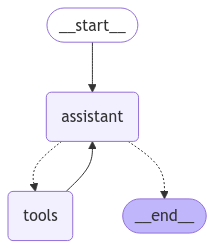

In [13]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph 
builder = StateGraph(MessagesState)

# Define nodes these do the work 
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges 
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assitant is a tool call -> tools_conditions routes to tools 
    # If the latest message (result) from assistant is not a tool call -> tools_conditions routes to END 
    tools_condition,
)

builder.add_edge("tools", "assistant")

react_graph = builder.compile()

# Show 
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [14]:
messages = [HumanMessage(content="Convert 100 USD to EUR.")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Convert 100 USD to EUR.
================================== Ai Message ==================================
Tool Calls:
  currency_convert (call_CCyQPAb0pKl67xIMSZFReNud)
 Call ID: call_CCyQPAb0pKl67xIMSZFReNud
  Args:
    amount: 100
    from_currency: USD
    to_currency: EUR
================================= Tool Message =================================
Name: currency_convert

85.0
================================== Ai Message ==================================

100 USD is equivalent to 85 EUR.


In [15]:
messages = [HumanMessage(content="Calculate simple interest for principal 1000, rate 5%, and time 2 years.")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Calculate simple interest for principal 1000, rate 5%, and time 2 years.
================================== Ai Message ==================================
Tool Calls:
  simple_interest (call_jutWX1A6OHVClmiOQE0t0sUe)
 Call ID: call_jutWX1A6OHVClmiOQE0t0sUe
  Args:
    P: 1000
    r: 5
    t: 2
================================= Tool Message =================================
Name: simple_interest

10000.0
================================== Ai Message ==================================

The simple interest for a principal amount of 1000 at a rate of 5% over 2 years is 100.


# Doing this based on just Langchain

In [16]:
from langchain.tools import tool

@tool
def simple_interest(P: float, r: float, t: float) -> float:
    """Calculate simple interest given principal P, rate r, and time t."""
    return P * (r / 100) * t

@tool
def compound_interest(P: float, r: float, n: int, t: float) -> float:
    """Calculate compound interest."""
    return P * (1 + r / (n * 100))**(n * t)

@tool
def currency_convert(amount: float, from_currency: str, to_currency: str) -> float:
    """Convert between currencies (static rates)."""
    rates = {
        "USD_to_EUR": 0.85,
        "EUR_to_USD": 1.18,
        "USD_to_GBP": 0.75,
        "GBP_to_USD": 1.33
    }
    key = f"{from_currency}_to_{to_currency}"
    if key in rates:
        return round(amount * rates[key], 2)
    else:
        raise ValueError(f"Conversion rate for {key} not available.")


In [ ]:
from langchain_openai import ChatOpenAI
from langchain.agents import initialize_agent
from langchain.agents.agent_types import AgentType

# Initialize the language model
llm = ChatOpenAI(model="gpt-4o")

# List of tools (our financial functions)
tools = [simple_interest, compound_interest, currency_convert]

# Create an agent that uses the tools
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,  # Zero-shot, reacts based on tool descriptions
    verbose=True
)


ValueError: ZeroShotAgent does not support multi-input tool simple_interest.

In [18]:
# Simple interest calculation
response = agent.run("Calculate simple interest for principal 1000, rate 5%, and time 2 years.")
print(response)

# Currency conversion
response = agent.run("Convert 100 USD to EUR.")
print(response)

# Compound interest calculation
response = agent.run("Calculate compound interest for 1500, rate 4%, compounded quarterly for 3 years.")
print(response)


NameError: name 'agent' is not defined

You're spot on! The shift from LangChain to LangGraph can feel disorienting because **the concept of the "agent" becomes much less visible** in LangGraph.

### Why the Agent Feels Invisible in LangGraph:
- **LangChain Agent**:  
   - The agent is **explicitly defined** using `initialize_agent()`.  
   - It dynamically chooses tools and decides the flow based on LLM reasoning.  
   - This feels more like a "one-call-to-rule-them-all" approach.  

- **LangGraph**:  
   - There's no **single "agent" object**.  
   - Instead, you define **nodes (functions)** and **edges (flow control)**, creating **modular and visible workflows**.  
   - **The agent emerges from the graph execution** rather than being a clearly defined object.

---

### Key Differences:
| Aspect                          | LangChain Agent                              | LangGraph (Agentless Approach)                  |
|---------------------------------|---------------------------------------------|------------------------------------------------|
| **Agent Definition**             | `initialize_agent()`                         | Graph with nodes/edges                         |
| **Tool Execution**               | LLM decides tool usage at runtime            | Explicit flow – you control when tools are run |
| **State Management**             | Memory (optional, attached to agent)         | Persistent state via graph checkpointers       |
| **Flow Control**                 | Implicit, reactive                          | Explicit, step-by-step graph                   |
| **Scaling**                      | Tricky with many tools                      | Scalable with clear workflows                  |

---

### Example Comparison:
#### **LangChain Agent:**
```python
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

response = agent.run("Calculate simple interest for 1000 at 5% over 2 years.")
```
- The agent feels like **one cohesive entity**.  
- LLM decides everything on the fly.  

---

#### **LangGraph (No "Visible" Agent):**
```python
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)  # LLM logic
builder.add_node("tools", ToolNode(tools))  # Tool execution

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

react_graph = builder.compile()
```
- No `initialize_agent()` is required.  
- The **flow is explicit** – nodes replace the agent.  

---

### Why This Feels Cleaner (But Invisible):
- **Nodes = Tools**  
- **Edges = Agent Decisions**  

Essentially, the **"agent" is the graph itself** – and that feels "invisible" because you're not defining a single object labeled as an agent. Instead, you're building the logic piece by piece.

---

### Why This is Beneficial:
- **Greater Control** – You control when tools are called and how results are handled.  
- **Reduced Guesswork** – No more relying on the LLM to "guess" what to do.  
- **Scaling Becomes Easier** – Adding nodes to the graph feels natural.  

---

### How to Think About It:
- In **LangChain**, the agent is like a **manager** – they handle everything dynamically.  
- In **LangGraph**, **you are the manager** – you control the workflow explicitly.

Would you like to see a more detailed LangGraph example that mirrors LangChain agents but with the graph structure fully visible?